In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from wrangle import wrangle_data
import modeling as m

#Tools to build machine learning models and reports
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.utils import class_weight


#Removes warnings and imporves asthenics
import warnings
warnings.filterwarnings("ignore")

In [2]:
random_seed=1969

In [3]:
df = wrangle_data()

In [4]:
df.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Target', 'Temp Delta [K]'],
      dtype='object')

In [5]:
dumb_cols = ['Type']
df = pd.get_dummies(df, columns = dumb_cols)

In [6]:
df = df.drop(columns=['UDI', 'Product ID'])

In [7]:
target_col = 'Target'

In [8]:
train, val, test = m.train_validate(df, stratify_col = target_col)

In [9]:
train.shape[0] + val.shape[0] + test.shape[0] == df.shape[0]

True

In [10]:
cont_columns = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Temp Delta [K]']

In [11]:
train_scaled, val_scaled, test_scaled = m.scale_cont_columns(train, val, test, cont_columns, scaler_model = 1)

In [12]:
X_train, y_train, X_val, y_val, X_test, y_test = m.train_val_test(train_scaled, val_scaled, test_scaled, target_col)

In [13]:
#Still guess the most prevelent class. Then calc recall for zero.

baseline = train['Target'].sum()/len(train['Target'])
baseline

0.03395833333333333

DummyClassifier strategy:

- “most_frequent”
- “prior”
- “stratified”
- “uniform”
- “constant” (*requires a contant arg)

default=”prior”

In [14]:
baseline0 = DummyClassifier(strategy='most_frequent', random_state=random_seed)
baseline1 = DummyClassifier(strategy='prior', random_state=random_seed)
baseline2 = DummyClassifier(strategy='stratified', random_state=random_seed)
baseline3 = DummyClassifier(strategy='uniform', random_state=random_seed)
baseline4 = DummyClassifier(strategy='constant', constant=0, random_state=random_seed)

In [15]:
baseline0.fit(X_train, y_train)
baseline1.fit(X_train, y_train)
baseline2.fit(X_train, y_train)
baseline3.fit(X_train, y_train)
baseline4.fit(X_train, y_train)

DummyClassifier(constant=0, random_state=1969, strategy='constant')

In [16]:
baseline0.predict(X_train)
baseline1.predict(X_train)
baseline2.predict(X_train)
baseline3.predict(X_train)
baseline4.predict(X_train)

array([0, 0, 0, ..., 0, 0, 0])

In [17]:
print(f'Score 0: {baseline0.score(X_train, y_train):.4f}')
print(f'Score 1: {baseline1.score(X_train, y_train):.4f}')
print(f'Score 2: {baseline2.score(X_train, y_train):.4f}')
print(f'Score 3: {baseline3.score(X_train, y_train):.4f}')
print(f'Score 4: {baseline4.score(X_train, y_train):.4f}')

Score 0: 0.9660
Score 1: 0.9660
Score 2: 0.9356
Score 3: 0.5040
Score 4: 0.9660


In [18]:
m.dec_tree(X_train, y_train, X_val, y_val, metric = 3)

Recall of Decision Tree classifier on training set:   0.7423
Recall of Decision Tree classifier on validation set: 0.6019
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3092
           1       0.76      0.60      0.67       108

    accuracy                           0.98      3200
   macro avg       0.87      0.80      0.83      3200
weighted avg       0.98      0.98      0.98      3200



In [19]:
m.rand_forest(X_train, y_train, X_val, y_val, metric = 3)

Recall of Random Forest classifier on training set:   0.9141
Recall of Random Forest classifier on validation set: 0.8704
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      3092
           1       0.39      0.87      0.54       108

    accuracy                           0.95      3200
   macro avg       0.69      0.91      0.75      3200
weighted avg       0.97      0.95      0.96      3200



In [20]:
m.knn_mod(X_train, y_train, X_val, y_val, metric = 3)

Recall of KNN classifier on training set:   0.3374
Recall of KNN classifier on validation set: 0.2500
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3092
           1       0.82      0.25      0.38       108

    accuracy                           0.97      3200
   macro avg       0.90      0.62      0.68      3200
weighted avg       0.97      0.97      0.97      3200



In [21]:
m.lr_mod(X_train, y_train, X_val, y_val, metric = 3)

Recall of Logistic Regression classifier on training set:   0.9509
Recall of Logistic Regression classifier on validation set: 0.9074
              precision    recall  f1-score   support

           0       0.99      0.42      0.59      3092
           1       0.05      0.91      0.10       108

    accuracy                           0.44      3200
   macro avg       0.52      0.66      0.34      3200
weighted avg       0.96      0.44      0.57      3200



### Tuning the algrothium paramaters

In [22]:
metrics = []

for i in range(1, 25):
    trees = DecisionTreeClassifier(max_depth=i, random_state=1969)
    trees = trees.fit(X_train, y_train)
        
    y_pred = trees.predict(X_train)
    y_pred_val = trees.predict(X_val)

    in_sample_accuracy = recall_score(y_train, y_pred)
    out_of_sample_accuracy = recall_score(y_val, y_pred_val)

    output = {"max_depth" : i, "train_accuracy": in_sample_accuracy, "validate_accuracy": out_of_sample_accuracy}
              
    metrics.append(output)

df_tune = pd.DataFrame(metrics)              
df_tune['difference'] = df_tune.train_accuracy - df_tune.validate_accuracy              

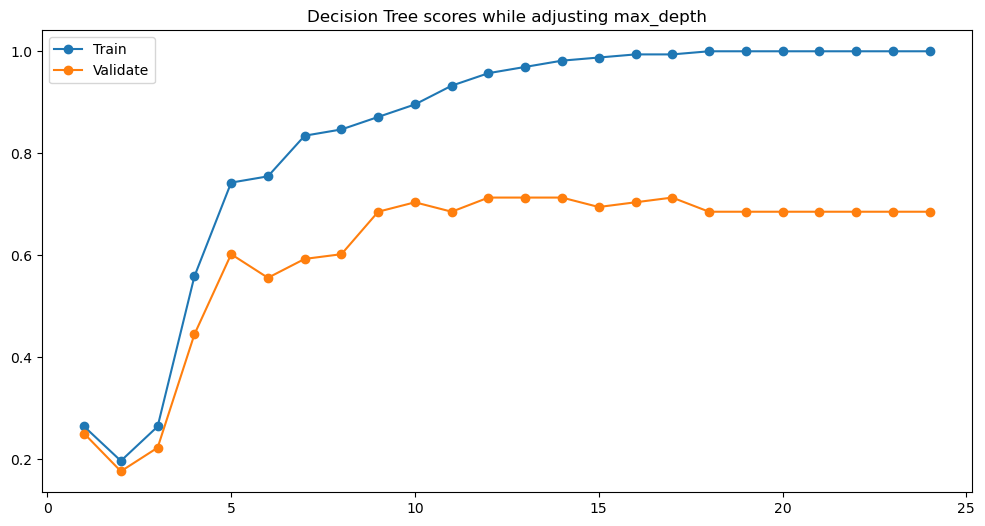

In [23]:

plt.figure(figsize=(12,6))
plt.plot(df_tune.max_depth, df_tune.train_accuracy, marker = 'o', label= 'Train')
plt.plot(df_tune.max_depth, df_tune.validate_accuracy, marker = 'o', label= 'Validate')
plt.legend()
plt.title("Decision Tree scores while adjusting max_depth")
plt.show()


In [24]:
metrics = []

for i in range(1, 20):
    rf_5 = RandomForestClassifier(max_depth=i,
                                  min_samples_leaf = 3,
                                  random_state= 1969,
                                  n_estimators = 100,
                                  criterion = 'entropy',
                                  class_weight='balanced')
    rf_5 = rf_5.fit(X_train, y_train)
    
    
    y_pred = rf_5.predict(X_train)
    y_pred_val = rf_5.predict(X_val)

    in_sample_accuracy = recall_score(y_train, y_pred)
    out_of_sample_accuracy = recall_score(y_val, y_pred_val)

    output = {"max_depth" : i, "train_accuracy": in_sample_accuracy, "validate_accuracy": out_of_sample_accuracy}
              
    metrics.append(output)

rand_forest = pd.DataFrame(metrics)              
rand_forest['difference'] = rand_forest.train_accuracy - rand_forest.validate_accuracy 

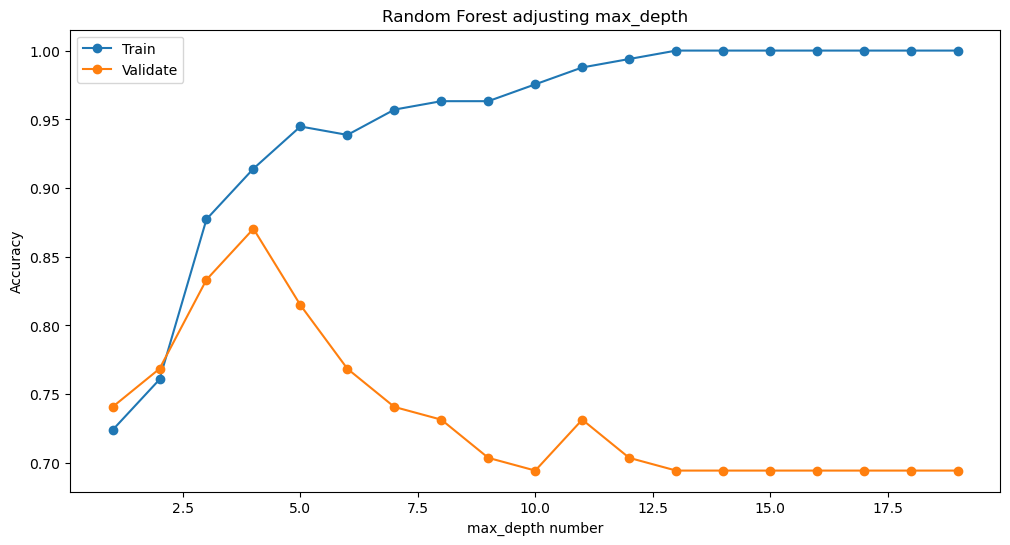

In [25]:

plt.figure(figsize=(12,6))
plt.plot(rand_forest.max_depth, rand_forest.train_accuracy, marker = 'o', label= 'Train')
plt.plot(rand_forest.max_depth, rand_forest.validate_accuracy, marker = 'o', label= 'Validate')
#plt.plot(rand_forest.max_depth, rand_forest.difference, marker = '.', label = 'Difference')

plt.legend()
plt.title("Random Forest adjusting max_depth")
plt.xlabel("max_depth number")
plt.ylabel("Accuracy")
plt.show()

In [26]:
metrics = []

for i in range(1, 21, 2): #Remember not to use even numbers to prevent gridlock.
    knn_5 = KNeighborsClassifier(n_neighbors=i)
    knn_5 = knn_5.fit(X_train, y_train)
    
    
    y_pred = knn_5.predict(X_train)
    y_pred_val = knn_5.predict(X_val)

    in_sample_accuracy = recall_score(y_train, y_pred)
    out_of_sample_accuracy = recall_score(y_val, y_pred_val)

    output = {"max_depth" : i, "train_accuracy": in_sample_accuracy, "validate_accuracy": out_of_sample_accuracy}
              
    metrics.append(output)

df_tune = pd.DataFrame(metrics)              
df_tune['difference'] = df_tune.train_accuracy - df_tune.validate_accuracy 

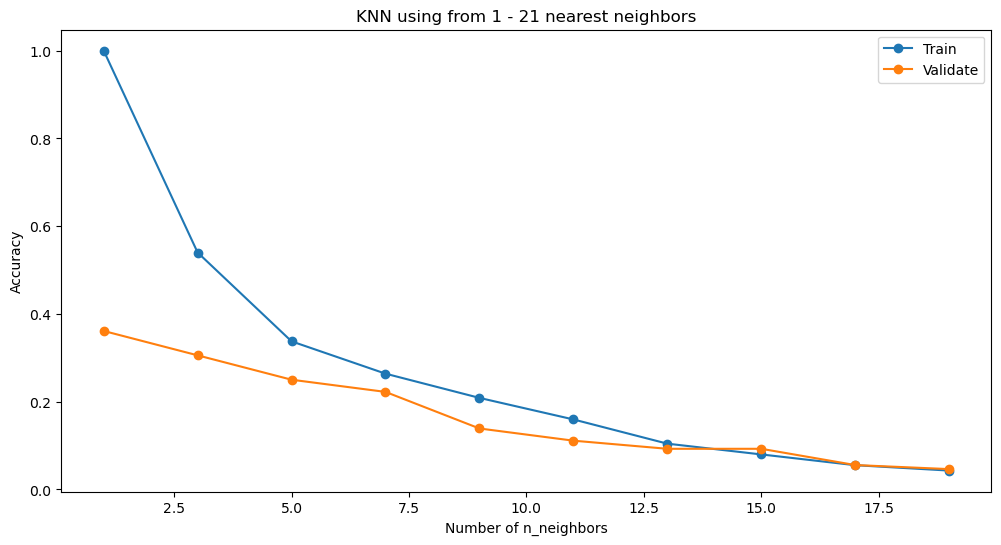

In [27]:

plt.figure(figsize=(12,6))
plt.plot(df_tune.max_depth, df_tune.train_accuracy, marker = 'o', label= 'Train')
plt.plot(df_tune.max_depth, df_tune.validate_accuracy, marker = 'o', label= 'Validate')
#plt.plot(df_tune.max_depth, df_tune.difference, marker = '.', label = 'Difference')
plt.legend()
plt.title("KNN using from 1 - 21 nearest neighbors")
plt.xlabel("Number of n_neighbors")
plt.ylabel("Accuracy")
plt.show()

‘lbfgs’ - [‘l2’, None]

‘liblinear’ - [‘l1’, ‘l2’]

‘newton-cg’ - [‘l2’, None]

‘newton-cholesky’ - [‘l2’, None] #Apparently this doesn't exist

‘sag’ - [‘l2’, None]

‘saga’ - [‘elasticnet’, ‘l1’, ‘l2’, None]

In [28]:
solver_list = ['lbfgs', 'newton-cg', 'sag', 'liblinear', 'saga']
metrics = []

for solver in solver_list:
    if (solver == 'lbfgs') or (solver == 'newton-cg') or (solver == 'sag'):
        penalties = ['l2', 'none']
    elif solver == 'liblinear':
        penalties = ['l1', 'l2']
    elif solver == 'saga':
        penalties = ['elasticnet', 'l1', 'l2', 'none']
    
    for penalty in penalties:
        if penalty == 'elasticnet':
            l1_ratio = 0.5
        else:
            l1_ratio = None
        logit = LogisticRegression(penalty = penalty, solver=solver, l1_ratio = l1_ratio, random_state= 1969, class_weight='balanced')
        logit.fit(X_train, y_train)
        
        
        y_pred = logit.predict(X_train)
        y_pred_val = logit.predict(X_val)

        in_sample_accuracy = recall_score(y_train, y_pred)
        out_of_sample_accuracy = recall_score(y_val, y_pred_val)
        
        output = {"solver_penalty" : f'{solver}_{penalty}',
                  "train_accuracy": in_sample_accuracy,
                  "validate_accuracy": out_of_sample_accuracy}
              
        metrics.append(output)

logit_df = pd.DataFrame(metrics)              
logit_df['difference'] = logit_df.train_accuracy - logit_df.validate_accuracy 

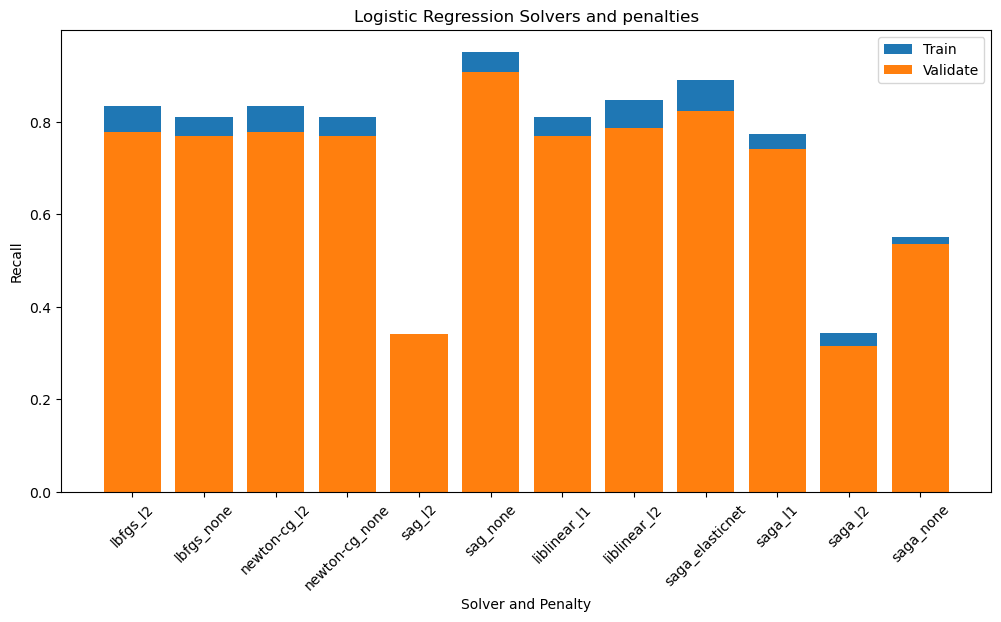

In [29]:
#Make a better bar plot
plt.figure(figsize=(12,6))
plt.bar(logit_df.solver_penalty, logit_df.train_accuracy, label= 'Train')
plt.bar(logit_df.solver_penalty, logit_df.validate_accuracy, label= 'Validate')
#plt.plot(logit_df.solver_penalty, logit_df.difference, marker = '.', label = 'Difference')

plt.legend()
plt.title("Logistic Regression Solvers and penalties")
plt.xlabel("Solver and Penalty")
plt.xticks(rotation = 45)
plt.ylabel("Recall")
plt.show()

In [30]:
#Up sampling
#Class weights

### Understanding Class weights

In [31]:
# Calculate weights using sklearn
sklearn_weights = class_weight.compute_class_weight('balanced', classes = np.unique(y_train), y = y_train)

In [32]:
sklearn_weights

array([ 0.51757602, 14.72392638])

In [33]:
#Manual calc:
majority_weight = 1/((len(train.Target)-train.Target.sum())/len(train.Target))
majority_weight

1.0351520379555748

In [34]:
#Manual calc:
minority_weight = 1/((train.Target.sum())/len(train.Target))
minority_weight

29.447852760736197

Why is the manual calc double what the automated calc is?